In [ ]:
!pip  install webrtcvad

In [6]:
import os
from os.path import isdir, join
from scipy.io import wavfile
from subprocess import check_output
from pathlib import Path
import pandas as pd

import soundfile as sf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import collections

import sys
import wave
import librosa
import webrtcvad

%matplotlib inline


# VAD 


In [7]:
def read_wave(path):
    """Reads a .wav file.

    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

def main(mode):
    # Input directory containing the language folders
    input_directory = '/kaggle/input/tamil-digits-final/Tamil-digits'
    
    # Output directory for segmented audio files
    output_directory = '/kaggle/working/'

    # Iterate over the folders in the input directory
    for folder_name in os.listdir(input_directory):
        folder_path = os.path.join(input_directory, folder_name)
        
        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Create corresponding output directory in the final dataset folder
            output_folder = os.path.join(output_directory, folder_name)
            os.makedirs(output_folder, exist_ok=True)
            
            # Iterate over the audio files in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                # Process the audio file
                audio, sample_rate = read_wave(file_path)
                vad = webrtcvad.Vad(int(mode))
                frames = frame_generator(30, audio, sample_rate)
                frames = list(frames)
                segments = vad_collector(sample_rate, 30, 300, vad, frames)
                
                # Extract the filename from the audio_file path
                file_name = os.path.basename(file_path)
                
                # Iterate over the segments and save them to the output folder
                for i, segment in enumerate(segments):
                    # Construct the output path with the same name as the input file
                    output_path = os.path.join(output_folder, file_name)
                    
                    print('Writing %s' % (output_path,))
                    write_wave(output_path, segment, sample_rate)


In [9]:
# Example usage
main(mode=3)

In [11]:
import os
import librosa
import soundfile as sf
import contextlib
import wave

# Function to convert a single audio file to mono
def convert_to_mono(input_file, output_dir):
    # Load the multi-channel audio file
    audio, sample_rate = librosa.load(input_file, sr=None, mono=False)

    # Convert the multi-channel audio to mono (single-channel)
    mono_audio = librosa.to_mono(audio)
    
    # Get the input file's name
    input_name = os.path.basename(input_file)

    # Construct the output file path
    output_file = os.path.join(output_dir, input_name)

    # Save the mono audio to the output file
    sf.write(output_file, mono_audio, sample_rate)
    
    # Check the number of channels in the saved file
    with contextlib.closing(wave.open(output_file, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1

# Input directory containing the language folders
input_directory = '/kaggle/input/language-recognition/Language-Recognition'

# Iterate over the folders in the input directory
for folder_name in os.listdir(input_directory):
    folder_path = os.path.join(input_directory, folder_name)
    if os.path.isdir(folder_path):
        # Create corresponding output directory in the working directory
        output_directory = os.path.join('/kaggle/working', folder_name)
        os.makedirs(output_directory, exist_ok=True)
        
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith('.wav'):
                # Convert the file to mono and save it to the output directory
                convert_to_mono(file_path, output_directory)


In [13]:
samples, sample_rate = librosa.load("/kaggle/working/Telugu-Test/000010387.wav")

ipd.Audio(samples, rate=sample_rate)

In [123]:
!rm -r /kaggle/working/*

In [ ]:
!zip -r /kaggle/working/Final.zip /kaggle/working/Tamil-digits


In [ ]:
import os
import librosa
import soundfile as sf
import contextlib
import wave

# Function to convert a single audio file to mono
def convert_to_mono(input_file, output_dir):
    # Load the multi-channel audio file
    audio, sample_rate = librosa.load(input_file, sr=None, mono=False)

    # Check if the audio has more than 1 channel
    if audio.shape[0] > 1:
        print(f"{input_file} is not mono channel.")
#         return

    # Convert the multi-channel audio to mono (single-channel)
    mono_audio = librosa.to_mono(audio)
    
    # Get the input file's name
    input_name = os.path.basename(input_file)

    # Construct the output file path
    output_file = os.path.join(output_dir, input_name)

    # Save the mono audio to the output file
    sf.write(output_file, mono_audio, sample_rate)
    
    # Check the number of channels in the saved file
    with contextlib.closing(wave.open(output_file, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1

# Input directory containing the language folders
input_directory = '/kaggle/input/language-recognition/Language-Recognition'

# Iterate over the folders in the input directory
for folder_name in os.listdir(input_directory):
    folder_path = os.path.join(input_directory, folder_name)
    if os.path.isdir(folder_path):
        # Create corresponding output directory in the working directory
        output_directory = os.path.join('/kaggle/working', folder_name)
        os.makedirs(output_directory, exist_ok=True)
        
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith('.wav'):
                # Convert the file to mono and save it to the output directory
                convert_to_mono(file_path, output_directory)


In [ ]:
import os
import librosa
import soundfile as sf

# Function to convert a single audio file to mono
def convert_to_mono(input_file, output_dir):
    # Load the audio file
    # Check the number of channels in the saved file
    with contextlib.closing(wave.open(input_file, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
    audio, sample_rate = librosa.load(input_file, sr=None, mono=False)

    # Check if the audio has more than 1 channel
    if audio.shape[0] != 1:
        print(f"{input_file} is not a mono channel.")
#         return

    # Get the input file's name
    input_name = os.path.basename(input_file)

    # Construct the output file path
    output_file = os.path.join(output_dir, input_name)

    # Save the mono audio to the output file
    sf.write(output_file, audio[0], sample_rate)  # Save only the first channel
    
    print(f"Mono audio file saved: {output_file}")

# Input directory containing the audio files
input_directory = '/kaggle/input/tamil-digits-final/Tamil-digits'

# Output directory for saving mono audio files
output_directory = '/kaggle/working'

# Iterate over the files in the input directory
for file_name in os.listdir(input_directory):
    file_path = os.path.join(input_directory, file_name)
    if file_name.endswith('.wav'):
        # Convert the file to mono and save it to the output directory
        convert_to_mono(file_path, output_directory)


In [ ]:
import os
import webrtcvad
import contextlib
import wave
import collections
import sys

def read_wave(path):
    """Reads a .wav file.

    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate, sample_width


def write_wave(path, audio, sample_rate, sample_width):
    """Writes a .wav file.

    Takes path, PCM audio data, sample rate, and sample width.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

def main(mode):
    # Input directory containing the language folders
    input_directory = '/kaggle/input/language-recognition/Language-Recognition'
    
    # Output directory for segmented audio files
    output_directory = '/kaggle/working/'

    # Iterate over the folders in the input directory
    for folder_name in os.listdir(input_directory):
        folder_path = os.path.join(input_directory, folder_name)
        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Create corresponding output directory in the final dataset folder
            output_folder = os.path.join(output_directory, folder_name)
            os.makedirs(output_folder, exist_ok=True)
            
            # Iterate over the audio files in the folder
            for file_name in os.listdir(folder_path):
                print(file_name)
                file_path = os.path.join(folder_path, file_name)
                
                # Process the audio file
                audio, sample_rate, sample_width = read_wave(file_path)
                vad = webrtcvad.Vad(int(mode))
                frames = frame_generator(30, audio, sample_rate)
                frames = list(frames)
                segments = vad_collector(sample_rate, 30, 300, vad, frames)
                
                # Extract the filename from the audio_file path
                file_name = os.path.basename(file_path)
                
                # Iterate over the segments and save them to the output folder
                for i, segment in enumerate(segments):
                    # Construct the output path with the same name as the input file
                    output_path = os.path.join(output_folder, file_name)
                    
                    print('Writing %s' % (output_path,))
                    write_wave(output_path, segment, sample_rate, sample_width)

main(3)


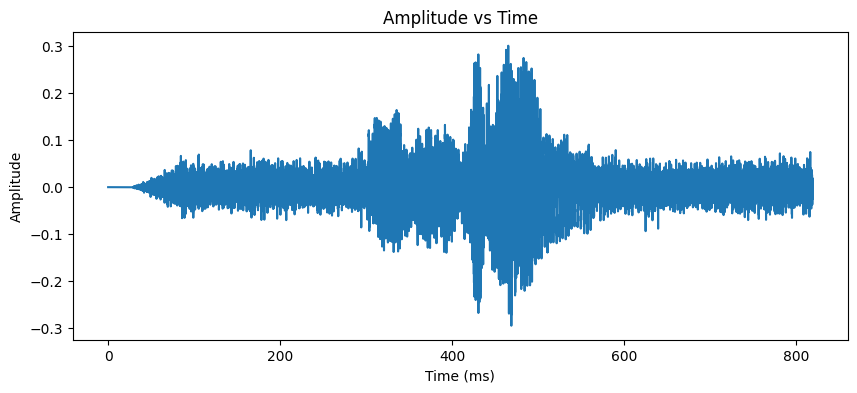

In [17]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/kaggle/input/tamil-digits/Tamil-Digits/0_v8.wav'
y, sr = librosa.load(audio_file)

# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()


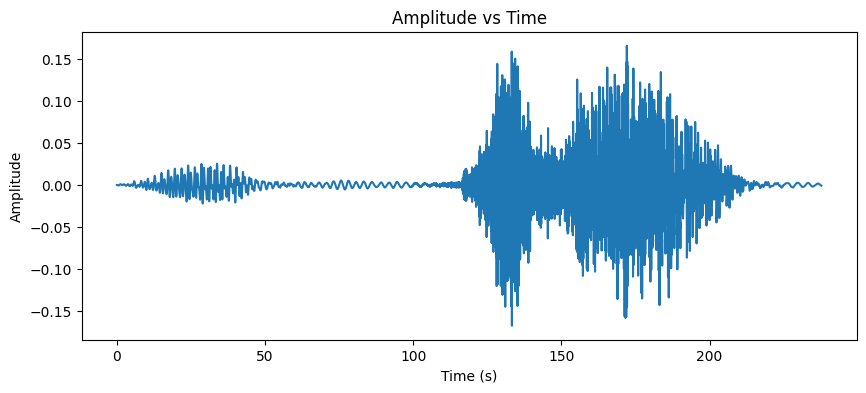

In [18]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/kaggle/input/tamil-digits-final/Tamil-digits/0_v8.wav'
y, sr = librosa.load(audio_file)
y, _= librosa.effects.trim(y, top_db=30)
# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()


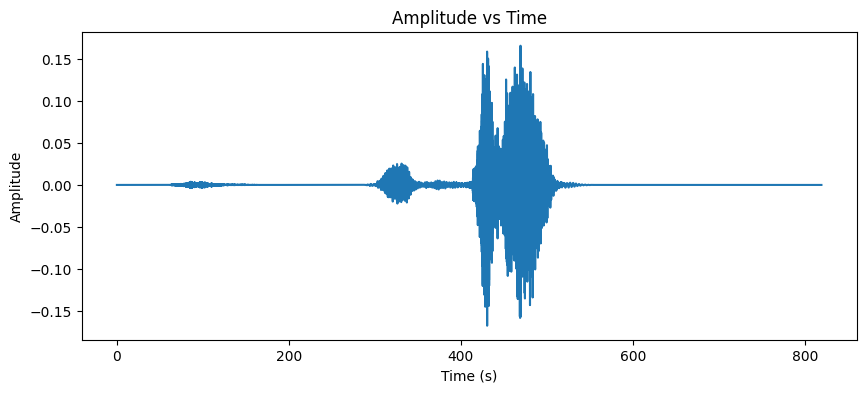

In [21]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/kaggle/input/tamil-digits-clean-vad/Tamil-digits/0_v8.wav'
y, sr = librosa.load(audio_file)

# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()
